In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sem
import scipy.linalg as la

In [2]:
N = 64
p = N - 1
Al, Bl, Cl, Dl, zl, wl = sem.semhat(p)
Q = np.zeros((N, N-1))
for i in range(N-1):
    Q[i,i] = 1
Q[-1,0] = 1
Qt = Q.transpose()
A = np.dot(Qt, np.dot(Al, Q))
B = np.dot(Qt, np.dot(Bl, Q))
D = np.dot(Qt, np.dot(Dl, Q))
A = np.dot(D.transpose(), np.dot(B, D))
C = np.dot(B, D)
z = zl[:-1]

In [3]:
Re = 100
visc = 2 / Re

def bdf1(dt, x):
    y = la.solve(B - dt * (C-visc*A), np.dot(B, x[:,0]))
    #f = np.dot(A, x) #+ np.dot(Cl, x)
    #y = x + dt * f
    return y

def bdf2(dt, x):
    rhs = np.dot(B, 4./3.*x[:,0]- 1./3.*x[:,1])
    scale = 2.*dt/3.
    y = la.solve(B - scale * (C-visc*A), rhs )
    return y

def bdf3(dt, x):
    rhs = np.dot(B, 18./11.*x[:,0]- 9./11.*x[:,1] + 2./11.*x[:,2])
    scale = 6.*dt/11.
    y = la.solve(B - scale * (C-visc*A), rhs )
    return y

def bdf4(dt, x):
    rhs = np.dot(B, 48./25.*x[:,0]- 36./25.*x[:,1] + 16./25.*x[:,2] - 3./25. * x[:,3])
    scale = 12.*dt/25.
    y = la.solve(B - scale * (C-visc*A), rhs )
    return y

def bdf5(dt, x):
    rhs = np.dot(B, 300./137.*x[:,0]- 300./137.*x[:,1] + 200./137.*x[:,2] - 75./137. * x[:,3] + 12./137. * x[:,4])
    scale = 60.*dt/137.
    y = la.solve(B - scale * (C-visc*A), rhs )
    return y

def bdf2opt(dt, x):
    beta = 0.48
    rhs_2 = 4./3.*x[:,0]- 1./3.*x[:,1]
    rhs_3 = 18./11.*x[:,0]- 9./11.*x[:,1] + 2./11.*x[:,2]
    rhs = np.dot(B, beta*rhs_3 + (1-beta)*rhs_2)
    scale = beta * 6.*dt/11. + (1-beta) * 2.*dt/3.
    y = la.solve(B - scale * (C-visc*A), rhs )
    return y

In [4]:
def simulate(IC, Cycles, dt, advance):
    NT = int(Cycles * 2 / dt)
    
    dat = np.zeros((IC.size, 5))
    dat[:,0] = IC
    
    adv = bdf1(dt, dat)
    dat = np.roll(dat, 1, 1)
    dat[:,0] = adv
    
    adv = bdf2(dt, dat)
    dat = np.roll(dat, 1, 1)
    dat[:,0] = adv

    for i in range(NT-2):
        adv = advance(dt, dat)
        dat = np.roll(dat, 1, 1)
        dat[:,0] = adv
        
    return adv



def calculate_error(IC, ref, Cycles, dt, advance):
    out = simulate(IC, Cycles, dt, advance)
        
    #err = np.exp(-np.square(z)/(4*visc*(2*Num + delta/(4*visc)) )) - bar
    err = ref - out
    norm = np.sqrt(np.dot(err.transpose(), np.dot(B, err)))
    return norm

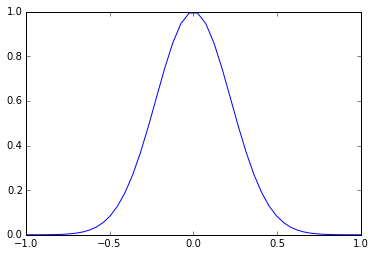

In [5]:
delta = .1
IC = np.exp(-np.square(z)/delta)
plt.plot(z, IC)

/home/maxhutch/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log2


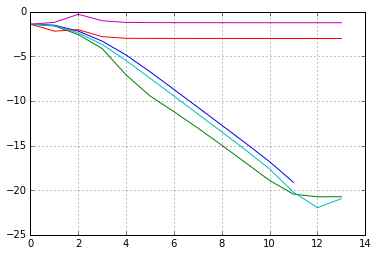

In [6]:
Cycles = 1
Re = 100
visc = 2 / Re

ref = simulate(IC, Cycles, 2.**(-12), bdf2)

nsamp = 14
dts = np.power(2., np.arange(0, -nsamp, -1))
errs_2 = np.zeros(nsamp)
errs_2o = np.zeros(nsamp)
errs_3 = np.zeros(nsamp)
errs_4 = np.zeros(nsamp)
errs_5 = np.zeros(nsamp)
for i in range(nsamp):
    errs_2[i]  = calculate_error(IC, ref, Cycles, dts[i], bdf2)
    errs_2o[i] = calculate_error(IC, ref, Cycles, dts[i], bdf2opt)
    errs_3[i]  = calculate_error(IC, ref, Cycles, dts[i], bdf3)
    errs_4[i]  = calculate_error(IC, ref, Cycles, dts[i], bdf4)
    errs_5[i]  = calculate_error(IC, ref, Cycles, dts[i], bdf5)
plt.plot(-np.log2(dts), np.log2(errs_2))
plt.plot(-np.log2(dts), np.log2(errs_3))
plt.plot(-np.log2(dts), np.log2(errs_4))
plt.plot(-np.log2(dts), np.log2(errs_2o))
plt.plot(-np.log2(dts), np.log2(errs_5))
plt.grid(True)

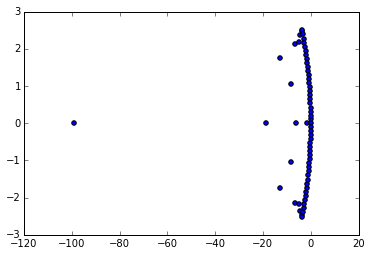

In [7]:
ev = la.eigvals(C-visc*A)
plt.scatter(np.real(ev), np.imag(ev))